In [1]:
import string
import warnings

import pandas as pd
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.calibration import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
warnings.filterwarnings("ignore")

## Import `Watch History` Dataset

In [3]:
from frontend.youtube import IngestYtHistory

In [4]:
df = pd.concat(
    [
        pd.read_json("data/allVideoDetails.json")[["title", "channelTitle", "id"]],
        IngestYtHistory("data/raw/itsarv.json")
        .initiate()
        .select("title", "channelTitle", pl.col("videoId").alias("id"))
        .to_pandas(),
        IngestYtHistory("data/raw/arv-anshul.json")
        .initiate()
        .select("title", "channelTitle", pl.col("videoId").alias("id"))
        .to_pandas(),
    ]
).drop_duplicates("id")
print(df.shape)
df.head()

(14792, 3)


,title,channelTitle,id
0,Arrow Function: Think Backwards,Visual Studio Code,4dgSwnKtVLo
1,python 3.12 release highlights (beginner - adv...,anthonywritescode,IV8OZY4194U
2,Australia's economy is WEIRD | Australia Econo...,Abhi and Niyu,4uM7RIfMLK4
3,Will India Change its Name to Bharat Permanently?,Dekho Isko,uWLooUi8in0
4,3 Amazing Indian Movies In 2023 That Deserve M...,Tried&Refused Productions.,diajsqMk-mo


## Import `Content-Type` Mapping Dataset

In [5]:
content_type_map = pd.read_json("data/contentTypeTaggedChannelNew.json")
content_type_map["contentType"].value_counts()

contentType
Programming         52
Movies & Reviews    37
Entertainment       35
News                27
Pseudo Education    14
Education           14
Music               13
Shorts              12
Tech                12
Vlogs               10
Reaction            10
Infotainment         8
Podcast              5
Finance              4
Psychology           4
                     1
Name: count, dtype: int64

In [6]:
content_type_map.query('contentType=="Music"')

,channelTitle,contentType
3,7clouds,Music
27,BLACKPINK,Music
68,Eros Now Music,Music
102,KaanPhod Music,Music
160,SANGEETARIST,Music
164,Saregama Music,Music
170,Shemaroo,Music
179,Sony Music India,Music
180,Sony Music South,Music
187,T-Series,Music


## Merge both dataset

In [7]:
df = df.merge(content_type_map)
df.head()

,title,channelTitle,id,contentType
0,Arrow Function: Think Backwards,Visual Studio Code,4dgSwnKtVLo,Programming
1,Make Folders FAST in #vscode like THIS!,Visual Studio Code,KQe2cyfIok4,Programming
2,Change my mind #code #windows #development,Visual Studio Code,9b4wsvlocUU,Programming
3,Code Runner,Visual Studio Code,zwit6f6Nuwk,Programming
4,Dev Containers in Your Terminal! #vscode #code,Visual Studio Code,hY4ydbV1X4k,Programming


In [8]:
df = df["contentType"].replace(
    {
        "Finance": "Pseudo Education",
        "Psychology": "Pseudo Education",
        "Podcast": "Pseudo Education",
    },
)

In [9]:
df["contentType"].value_counts()

contentType
Programming         2339
Movies & Reviews    2330
News                1829
Pseudo Education    1076
Entertainment        883
Infotainment         735
Tech                 334
Education            298
Reaction             232
Shorts               212
Music                202
Vlogs                201
Name: count, dtype: int64

### Remove shorts titles

In [10]:
no_shorts_df = df[
    (~df["title"].str.contains("#short", case=False)) & (df["contentType"] != "Shorts")
]
no_shorts_df.shape

(9842, 4)

## Building ML model

### Split Dataset

In [11]:
_t = no_shorts_df

In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    _t["title"],  # .add(" ").add(_t["channelName"]),
    _t["contentType"],
    test_size=0.2,
    random_state=42,
)
X_train.shape, X_test.shape

((7873,), (1969,))

### Combine Dataset into One

In [13]:
_t.loc[:, "title"] = _t["title"].add(" ")
combined_title_df = _t.groupby("contentType")["title"].sum().reset_index()
combined_title_df

,contentType,title
0,Education,Famous Brand Fries vs Home-made Fries😮 I Scien...
1,Entertainment,I woke up one day and I couldn’t see anything…...
2,Infotainment,Will India Change its Name to Bharat Permanent...
3,Movies & Reviews,3 Amazing Indian Movies In 2023 That Deserve M...
4,Music,"Alan Walker - Faded (Lyrics) Alan Walker, K-39..."
5,News,India Middle East Europe economic corridor wil...
6,Programming,Arrow Function: Think Backwards Make Folders F...
7,Pseudo Education,Australia's economy is WEIRD | Australia Econo...
8,Reaction,Latinos React to Indian Idol Season 14 Auditio...
9,Tech,The EU Will Break Apple. Me Want Big SSD We Go...


## Functions for model building

In [14]:
def preprocessor(s: str):
    """Proprecessor for Vectorizer."""
    s = s.translate(str.maketrans("", "", string.punctuation))
    ps = PorterStemmer()
    s = " ".join([ps.stem(i) for i in s.split() if i.isascii()])
    return s

In [15]:
def get_vectorizer(text_arr):
    vectorizer = TfidfVectorizer(
        preprocessor=preprocessor,
        max_features=7_000,
        ngram_range=(1, 2),
        stop_words="english",
    )
    return vectorizer.fit(text_arr)


def train_model(model, X, y):
    label_enc = LabelEncoder()
    y_enc = label_enc.fit_transform(y)
    X_vec = vectorizer.transform(X)

    model.fit(X_vec, y_enc)
    return model, label_enc


def predict(X):
    X_vec = vectorizer.transform(X)
    return model.predict(X_vec)


def calc_score(y_true, y_pred):
    y_true_enc = label_enc.transform(y_true)
    return accuracy_score(y_true_enc, y_pred)


def plot_confusion_matrix(y_test, y_pred):
    y_test_enc = label_enc.transform(y_test)
    plot_labels = label_enc.classes_.tolist()

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        confusion_matrix(y_test_enc, y_pred),
        annot=True,
        fmt="d",
        cbar=False,
        cmap="YlGnBu",
    )
    plt.xticks([i + 0.5 for i in range(len(plot_labels))], plot_labels, rotation=90)
    plt.yticks([i + 0.5 for i in range(len(plot_labels))], plot_labels, rotation=0)
    plt.show()


def word_to_vec(*s: str):
    return vectorizer.inverse_transform(vectorizer.transform(s))


def inverse_predict(*s: str):
    return label_enc.inverse_transform(model.predict(vectorizer.transform(s)))


def get_bad_predictions(X_test, y_true, y_pred):
    y_true_vec = label_enc.transform(y_true)
    temp = pd.DataFrame()

    bool_map = y_true_vec != y_pred
    temp["title"] = X_test[bool_map]
    temp["y_true"] = y_true[bool_map]
    temp["y_pred"] = label_enc.inverse_transform(y_pred)[bool_map]
    return temp

In [16]:
# Train with X_train and y_train
vectorizer = get_vectorizer(X_train)
model, label_enc = train_model(MultinomialNB(alpha=0.1), X_train, y_train)
y_pred = predict(X_test)
print(f"Accuracy Score: {calc_score(y_test, y_pred):.3}")

Accuracy Score: 0.808


In [17]:
# Train with combined_title_df
vectorizer = get_vectorizer(combined_title_df["title"])
model, label_enc = train_model(
    MultinomialNB(alpha=0.1),
    combined_title_df["title"],
    combined_title_df["contentType"],
)

y_pred = predict(X_test)
print(f"Accuracy Score: {calc_score(y_test, y_pred):.3}")

Accuracy Score: 0.787


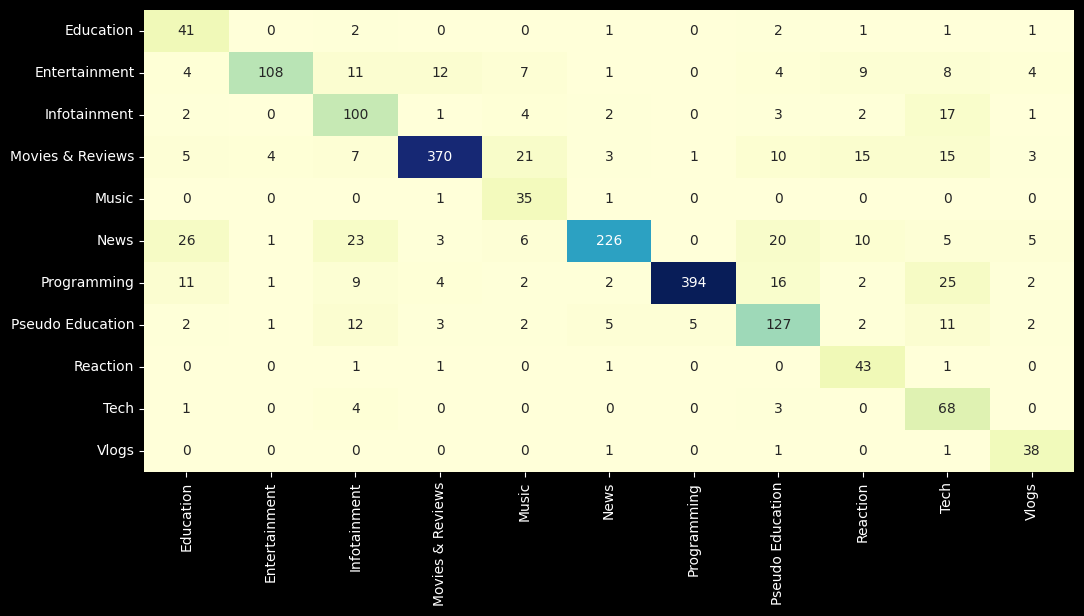

In [18]:
plot_confusion_matrix(y_test, y_pred)

In [27]:
missed_df = get_bad_predictions(X_test, y_test, y_pred)
missed_df["y_true"].value_counts()

y_true
News                99
Movies & Reviews    84
Programming         74
Entertainment       60
Pseudo Education    45
Infotainment        32
Education            8
Tech                 8
Reaction             4
Vlogs                3
Music                2
Name: count, dtype: int64

In [28]:
missed_df["y_pred"].value_counts()

y_pred
Tech                84
Infotainment        69
Pseudo Education    59
Education           51
Music               42
Reaction            41
Movies & Reviews    25
Vlogs               18
News                17
Entertainment        7
Programming          6
Name: count, dtype: int64

In [29]:
missed_df[["y_true", "y_pred"]].value_counts()

y_true            y_pred          
News              Education           26
Programming       Tech                25
News              Infotainment        23
Movies & Reviews  Music               21
News              Pseudo Education    20
                                      ..
Movies & Reviews  Programming          1
Music             Movies & Reviews     1
                  News                 1
News              Entertainment        1
Vlogs             Tech                 1
Name: count, Length: 74, dtype: int64

In [31]:
missed_df[missed_df["y_true"] == "Tech"]

,title,y_true,y_pred
6045,How Apple is Winning India!,Tech,Infotainment
1152,𝕏,Tech,Education
1589,I Lost Money on the India's Biggest Platform!,Tech,Infotainment
1141,Europe Will Save Us,Tech,Pseudo Education
1599,How REDMI is Destroying REALME?,Tech,Pseudo Education
10546,How a Tragic Childhood Lifted Elon Musk to the...,Tech,Infotainment
1139,"Watch Out, Apple...",Tech,Infotainment
1583,Why Indian TECH Companies SCAM Indians?,Tech,Pseudo Education


In [26]:
_t[_t["title"].str.contains("SQL Course Movie Trailer")]

,title,channelTitle,id,contentType
6308,SQL Course Movie Trailer,codebasics,ezrT1H-6DMY,Programming


In [22]:
s = [
    "code is fun, and you are awesome.",
    "abhi and niyu",
    "campusx writes code and krish naik teaches ML.",
    "tere te | new music | T-series | Guru Randhawa | Music",
    "GitHub Universe 2023 day 2 keynote",
    "samsung mobile with new feature",
    "How British LOOTED India?",
    "Equality is a SCAM",
    "Finally अमेरिका ने भारत को बेच ही दिया अपना माल ! | |by Ankit Avasthi Sir",
]

In [23]:
inverse_predict(*s)

array(['Programming', 'Pseudo Education', 'Programming', 'Music',
       'Programming', 'Tech', 'News', 'Infotainment', 'Education'],
      dtype=object)

In [24]:
word_to_vec(*s)

[array(['fun', 'code', 'awesom'], dtype='<U28'),
 array(['niyu', 'abhi niyu', 'abhi'], dtype='<U28'),
 array(['write', 'teach', 'naik', 'ml', 'krish naik', 'krish', 'code',
        'campusx'], dtype='<U28'),
 array(['tseri', 'tere', 'new', 'music'], dtype='<U28'),
 array(['univers', 'github', 'day', '2023'], dtype='<U28'),
 array(['samsung', 'new featur', 'new', 'mobil', 'featur'], dtype='<U28'),
 array(['loot', 'india', 'british'], dtype='<U28'),
 array(['scam', 'equal'], dtype='<U28'),
 array(['sir', 'final', 'avasthi sir', 'avasthi', 'ankit avasthi', 'ankit'],
       dtype='<U28')]